# Uncertainy intervals

## Modeling uncertainty in trends

You may have noticed in different component plots throughout this book that the trend 
shows uncertainty bounds, while the seasonality curves do not. By default, Prophet only 
estimates uncertainty in the trend, plus uncertainty due to random noise in the data. 
The noise is modeled as a normal distribution around the trend and trend uncertainty is 
modeled with **maximum a posteriori (MAP) estimation**.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import numpy as np
np.random.seed(42)


In [3]:
URL = 'https://raw.githubusercontent.com/PacktPublishing/Forecasting-Time-Series-Data-with-Facebook-Prophet/main/data/baltimore_crime.csv'
df = pd.read_csv(URL)
df.columns = ['ds', 'y']

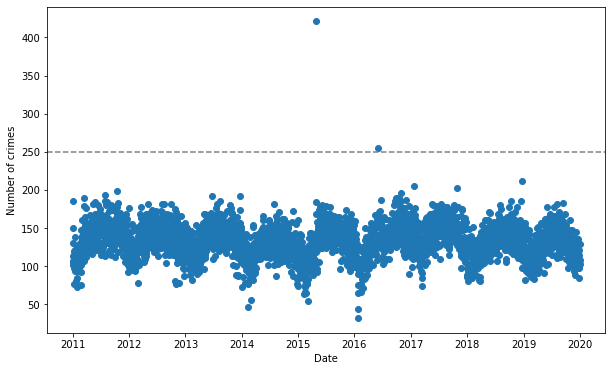

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(pd.to_datetime(df['ds']), df['y'])
plt.axhline(250, ls='--', c='gray')
plt.xlabel('Date')
plt.ylabel('Number of crimes')
plt.show()

In [5]:
df.loc[df['y'] > 250, 'y'] = None

The number of Monte Carlo simulations Prophet runs through is set with the 
`uncertainty_samples` argument during model instantiation. By default, it is set to 
`1000`, so Prophet simulates `1,000` different future trend lines and uses these to estimate 
uncertainty

In [6]:
model = Prophet(uncertainty_samples=1000)
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -48.3715


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6609.94   0.000159674       117.402   7.882e-07       0.001      158  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       6612.62    0.00040981        51.177   8.376e-06       0.001      276  LS failed, Hessian reset 
     199        6613.1    0.00082159       252.514           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6613.84    0.00015357       55.1822      0.6408      0.6408      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6614.57     0.0223975       260.527           1           1      582   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     410       6614.89    0.00104301        83.007   1.27

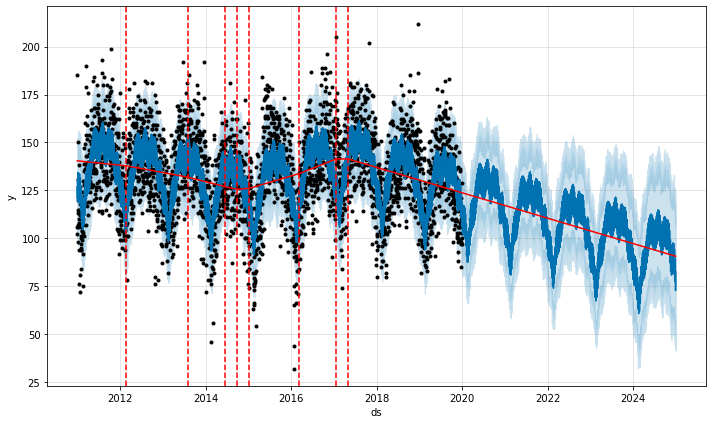

In [7]:
future = model.make_future_dataframe(periods=365 * 5)
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

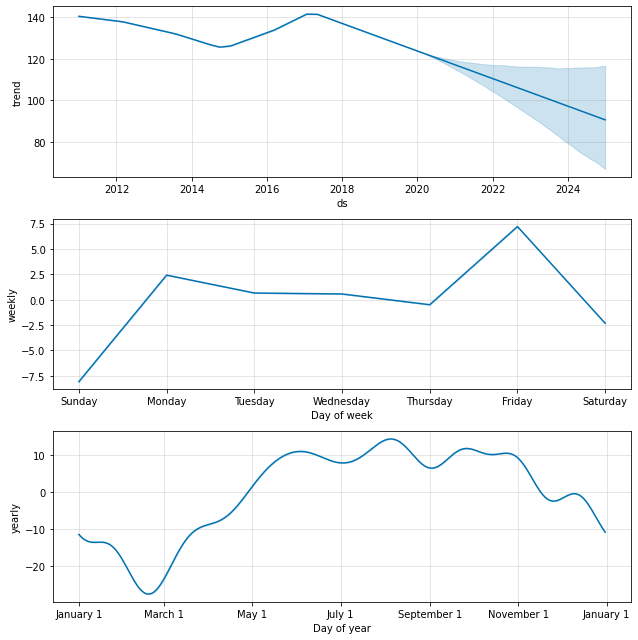

In [8]:
fig2 = model.plot_components(forecast)
plt.show()

In [9]:
# Saving for use later
m0 = model
f0 = forecast

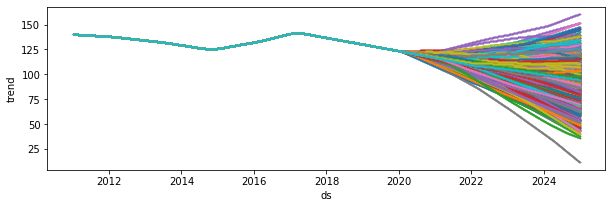

In [11]:
samples = model.predictive_samples(future)

plt.figure(figsize=(10, 3))
for idx in range(model.uncertainty_samples):
    plt.scatter(future['ds'], samples['trend'][:, idx], s=.1, alpha=1)
plt.xlabel('ds')
plt.ylabel('trend')
plt.show()

In [12]:
model = Prophet(interval_width=0.99)
model.fit(df)
future = model.make_future_dataframe(periods=365 * 5)
forecast = model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -48.3715
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6609.94   0.000159674       117.402   7.882e-07       0.001      158  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       6612.62    0.00040981        51.177   8.376e-06       0.001      276  LS failed, Hessian reset 
     199        6613.1    0.00082159       252.514           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6613.84    0.00015357       55.1822      0.6408      0.6408      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6614.57     0.0223975       260.527           1           1      582   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     410       6

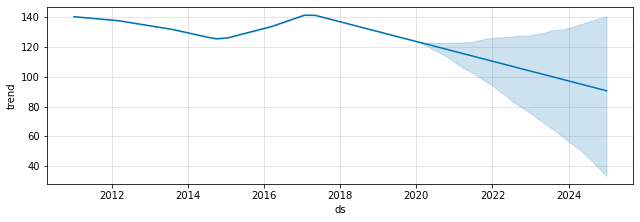

In [14]:
from prophet.plot import plot_forecast_component

plot_forecast_component(model,
                        forecast,
                        'trend',
                        figsize=(10.5, 3.25))
plt.show()